#### Integrin
#### DMap and decoder
#### reference notebook: cg_300_integrated_training_integrin_dmap_decoder.ipynb

## setup

In [1]:
import os
import sys
import math
import time
import pickle
import copy
#import mdtraj
import MDAnalysis as mda
#import pyemma
#import pyemma.util.contexts
import networkx as nx
import random
#import parmed as pmd
import acpype
import pandas as pd
from MDAnalysis.analysis import distances


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
#import torch.optim as optim
#import torch.nn as nn
#from torchviz import make_dot
#from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.utils.data.dataset import random_split
#from tqdm import tqdm

#import deeptime
#from deeptime.decomposition import TICA
#from deeptime.clustering import KMeans
##import mdshare

from sklearn.preprocessing import MinMaxScaler

from jax import numpy as jnp, jit, vmap
from MDAnalysis.analysis import rms #diffusionmap, align, rms

import nglview as nv


no display found. Using non-interactive Agg backend


In [2]:
#from lss.snrv.snrv import Snrv, load_snrv
#from env_snrv.molgen.molgen.models import WGANGP
from importlib import reload 

import sys
sys.path.append('../../..')
from env_snrv.molgen.molgen.models import WGANGP


import codes.dMap_JAX 
reload(codes.dMap_JAX )

from codes.dMap_JAX import dMap_jax, rmsd_jax
from codes.dMap_JAX import diff_plots




#### plot settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#### load saved integrin trajectories 

In [4]:
#### save eigen values

with open(r"../../gan_saved_models/integrin_aa_cg_300_original_aligned_2450_pertraj.pkl", "rb") as input_file:
    saved_traj = pickle.load(input_file)

cat_trajs = saved_traj['cat_trajs']
aligned_cat_trajs = saved_traj['aligned_cat_trajs']
aligned_cat_excl_trajs = saved_traj['aligned_cat_excl_trajs']


#### load dMaps

In [5]:
#### save eigen values

with open(r"../../gan_saved_models/evecs_evals_integrin_aa_cg_300.pkl", "rb") as input_file:
    dMaps_saved = pickle.load(input_file)

lamb = dMaps_saved['lamb']
psi = dMaps_saved['psi']

##### out-of-sample points

In [6]:
#### save eigen values

#with open(r"evecs_evals_nystrom_integrin_aa_cg_300.pkl", "rb") as input_file:
#    dMaps_saved_out = pickle.load(input_file)
#
#lamb_out = dMaps_saved_out['lamb']
#psi_out = dMaps_saved_out['psi']

In [7]:
#assert (lamb == lamb_out).all()

#### Decoder on the net data

In [8]:

from molgen.models import WGANGP
import torch


In [9]:
#cat_trajs.shape

#### visualize, if needed

In [ ]:
### create a universe for CG model [from example in MDAnalysis]

n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe
f_cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates




### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

f_cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
f_cg_1_universe.add_TopologyAttr('segid', ['INT'])



In [20]:

#### frame 0 positions

f_cg_1_universe.atoms.positions = aligned_cat_trajs[0]
f_cg_1_universe.load_new(np.array(aligned_cat_trajs), format=MemoryReader)


view = nv.show_mdanalysis(f_cg_1_universe)

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=2.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=2.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=9799)

#### prepare for decoder

In [10]:
real_trj_list = [aligned_cat_trajs[0:2450].reshape(2450, -1),
                 aligned_cat_trajs[2450:2450*2].reshape(2450, -1),
                 aligned_cat_trajs[2450*2:2450*3].reshape(2450, -1), 
                 aligned_cat_trajs[2450*3:2450*4].reshape(2450, -1)]

real_trj_list = [torch.tensor(x).float() for x in real_trj_list]

print(real_trj_list[0].shape)

psi_list = [psi[0:2450, 1:5],
            psi[2450:2450*2, 1:5],
            psi[2450*2:2450*3, 1:5],
            psi[2450*3:2450*4, 1:5]]

psi_list = [torch.tensor(x) for x in psi_list]

print(psi_list[0].shape)

#psi_out_list = [psi_out[0:2450, 1:5],
#            psi_out[2450:2450*2, 1:5],
#            psi_out[2450*2:2450*3, 1:5],
#            psi_out[2450*3:2450*4, 1:5]]
#
#psi_out_list = [torch.tensor(x) for x in psi_out_list]
#
#print(psi_out_list[0].shape)
#

torch.Size([2450, 900])
torch.Size([2450, 4])


In [11]:
print(psi_list[0].shape[1])
real_trj_list[0].shape[1]

4


900

In [12]:

f_model_gan = WGANGP(feature_dim=real_trj_list[0].shape[1], condition_dim=psi_list[0].shape[1], 
                     gen_hidden_dim=256, dis_hidden_dim=256, lambda_gp=10.0, n_critic=5, 
                     latent_dim=128, lr=5e-5, opt='rmsprop')
             

In [13]:
f_model_gan

WGANGP(
  (generator): SimpleGenerator(
    (model): Sequential(
      (0): Linear(in_features=132, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Linear(in_features=256, out_features=900, bias=True)
      (10): Tanh()
    )
  )
  (discriminator): SimpleDiscriminator(
    (model): Sequential(
      (0): Linear(in_features=904, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6)

#### train, if needed

In [15]:
#import os
#del os.environ['LD_LIBRARY_PATH']
#del os.environ['PATH']
#
#f_model_gan.fit(real_trj_list, psi_list, batch_size=1000, max_epochs=1000, log=True)
#
#

/work2/03273/tg825722/shared-folder-siva/doe/env_snrv/lss/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 34: CUDA driver is a stub library (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home1/03273/tg825722/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home1/03273/tg825722/.local/lib/python3.9/site-pack ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home1/03273/tg825722/.

Training: 0it [00:00, ?it/s]

/home1/03273/tg825722/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


WGANGP(
  (generator): SimpleGenerator(
    (model): Sequential(
      (0): Linear(in_features=132, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Linear(in_features=256, out_features=900, bias=True)
      (10): Tanh()
    )
  )
  (discriminator): SimpleDiscriminator(
    (model): Sequential(
      (0): Linear(in_features=904, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6)

In [14]:
#f_model_gan.save('wgangp_b_1000_e1000.ckpt')

In [14]:
f_model_gan = f_model_gan.load_from_checkpoint('../../gan_saved_models/wgangp_b_100_e1000.ckpt')

In [34]:
gan_logs = pd.read_csv('../../molgen_logs/version_13/metrics.csv')
# version 13 is the final [use it for plotting]

In [35]:
#gan_logs

In [16]:
##plot_stride = 100
#%matplotlib inline
#fig = plt.figure(figsize = (6,4))
#
#ax = fig.add_subplot(111)
#ax.scatter(gan_logs.epoch, gan_logs.g_loss, color='deepskyblue')
#ax.plot(gan_logs.epoch, gan_logs.g_loss, lw=2.5, color='deepskyblue')
#
#ax.set_xlabel('$epoch$', fontsize=15)
#ax.set_ylabel('$Generator~loss$', fontsize=15)
#
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#
#plt.ylim(-20, 0)
#plt.show()
#    
##fig.savefig('molgen_gloss_training_curve_b100.png', dpi=300)
#plt.close()
#

In [15]:
##plot_stride = 100
#fig = plt.figure(figsize = (6,4))
#
#ax = fig.add_subplot(111)
#ax.scatter(gan_logs.epoch, gan_logs.d_loss, color='deepskyblue')
#ax.plot(gan_logs.epoch, gan_logs.d_loss, lw=2.5, color='deepskyblue')
#
#ax.set_xlabel('$epoch$', fontsize=15)
#ax.set_ylabel('$Critic~loss$', fontsize=15)
#
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#
#plt.show()
#    
##fig.savefig('molgen_dloss2_training_curve_b100.png', dpi=300)
#plt.close()
#

In [6]:
##plot_stride = 100
#fig = plt.figure(figsize = (6,4))
#
#ax = fig.add_subplot(111)
#ax.scatter(gan_logs.epoch, gan_logs.d_loss_was)
#ax.plot(gan_logs.epoch, gan_logs.d_loss_was, lw=2.5)
#
#ax.set_xlabel('$epoch$')
#ax.set_ylabel('$Discriminator~loss$')
#
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#
#plt.show()
#    
##fig.savefig('molgen_dloss_training_curve_b100_e250.png', dpi=300)
#plt.close()
#

In [7]:
##plot_stride = 100
#fig = plt.figure(figsize = (6,4))
#
#ax = fig.add_subplot(111)
#ax.scatter(gan_logs.epoch, gan_logs.gp)
#ax.plot(gan_logs.epoch, gan_logs.gp, lw=2.5)
#
#ax.set_xlabel('$epoch$')
#ax.set_ylabel('$Gradient~penality$')
#
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#
#plt.show()
#    
##fig.savefig('molgen_gp_training_curve_b100_e500.png', dpi=300)
#plt.close()
#

#### generate fake points corresponding to training set points

In [17]:
#gen_traj = []
#for i in range(4):
#    gen_traj.append(f_model_gan.generate(psi_list[i]))
#
#out_gen_traj = []
#for i in range(4):
#    out_gen_traj.append(f_model_gan.generate(psi_out_list[i]))
    

#### convert to torch tensors

In [18]:
#gen_traj_list = [torch.tensor(x).clone().detach() for x in gen_traj]
#
#for i in range(4):
#    gen_traj_list[i] = gen_traj_list[i].reshape(2450, 300, 3)
#    
#    
#out_gen_traj_list = [torch.tensor(x).clone().detach() for x in out_gen_traj]
#
#for i in range(4):
#    out_gen_traj_list[i] = out_gen_traj_list[i].reshape(2450, 300, 3)
#

In [19]:
#print(gen_traj_list[0].shape)
#print(out_gen_traj_list[0].shape)

In [20]:
### create a universe for CG model [from example in MDAnalysis]

#n_residues = 300
#n_atoms = n_residues
#
## create resindex list
#resindices = np.arange(n_residues)
#
## all water molecules belong to 1 segment
#segindices = [0] * n_residues
#
## create the Universe -- for train
#f_cg_1_universe = mda.Universe.empty(n_atoms,
#                                 n_residues=n_residues,
#                                 atom_resindex=resindices,
#                                 residue_segindex=segindices,
#                                 trajectory=True) # necessary for adding coordinates
#
## create the Universe -- for valid -- out
#f_cg_2_universe = mda.Universe.empty(n_atoms,
#                                 n_residues=n_residues,
#                                 atom_resindex=resindices,
#                                 residue_segindex=segindices,
#                                 trajectory=True) # necessary for adding coordinates
#
#

In [21]:
  
#combine_orig_gen_traj = np.concatenate(( np.concatenate(gen_traj, axis=0).reshape(-1,300,3), aligned_cat_trajs))
#combine_orig_gen_traj = np.array(combine_orig_gen_traj)
#print(combine_orig_gen_traj.shape)
#
#out_combine_orig_gen_traj = np.concatenate(( np.concatenate(out_gen_traj, axis=0).reshape(-1,300,3), aligned_cat_excl_trajs))
#out_combine_orig_gen_traj = np.array(out_combine_orig_gen_traj)
#print(out_combine_orig_gen_traj.shape)
#
##### save aligned catenated trajectory
#
#with open(r"integrin_aa_cg_300_original_generated_2450_pertraj_b100_e1000.pkl", "wb") as f:
#    pickle.dump({'combine_orig_gen_traj': np.array(combine_orig_gen_traj),
#                 'out_combine_orig_gen_traj': np.array(out_combine_orig_gen_traj)}, f)
#    
#    

In [22]:
#### topology attributes
#from MDAnalysis.coordinates.memory import MemoryReader
#
#f_cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
#f_cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
#f_cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
#f_cg_1_universe.add_TopologyAttr('segid', ['INT'])
#
##### frame 0 positions
#
#f_cg_1_universe.atoms.positions = combine_orig_gen_traj[2450*3]
#
#f_cg_1_universe.load_new(np.array(combine_orig_gen_traj[2450*3:4*2450]), format=MemoryReader)
#
#
#f_cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
#f_cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
#f_cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
#f_cg_1_universe.add_TopologyAttr('segid', ['INT'])
#
##### frame 0 positions
#
#f_cg_1_universe.atoms.positions = out_combine_orig_gen_traj[2450*3]
#
#f_cg_1_universe.load_new(np.array(out_combine_orig_gen_traj[2450*3:4*2450]), format=MemoryReader)
#

In [23]:
#view = nv.show_mdanalysis(f_cg_1_universe)
#
## clear representations
##view.clear_representations()
#
##view.add_representation('spacefill')
#view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
##?view.center_view()
#
## specify color
#view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=1.5, opacity=0.85)
#view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=1.5, opacity=0.85)
#view.add_representation('cartoon', color='black')
#
#
#view

#### Decode all points over relevant space for calculating key basic metrics (distances)

In [21]:
##### real and fake -- extract fake
#with open(r"../../gan_saved_models/integrin_aa_cg_300_original_generated_2450_pertraj_b100_e1000.pkl", "rb") as input_file:
#    get_combine_orig_gen_traj = pickle.load(input_file)
#    
#    
#get_gen_traj = get_combine_orig_gen_traj['combine_orig_gen_traj'][:9800]
#
#get_gen_traj.shape

In [18]:
latent_points[0].shape

(10, 4)

In [19]:
psi1_psi2_space = np.concatenate(psi_list, axis=0)

n = 10
xy_min = [1*psi1_psi2_space[:,0].min(), 1*psi1_psi2_space[:,1].min(), 
          psi1_psi2_space[:,2].min(), psi1_psi2_space[:,3].min()]
xy_max = [1*psi1_psi2_space[:,0].max(), psi1_psi2_space[:,1].max(), 
          1*psi1_psi2_space[:,2].max(), psi1_psi2_space[:,3].max()]


#xy_min = [0.000043,-0.000098, 0.000095, 0.000195]
#xy_max = [-0.000006, -0.000095, 0.000102, 0.000260]

psi1_psi2_space_data_1 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(20000,4))

xy_min = [0.00014,-0.000111,-0.000047,  0.000088]
xy_max = [-0.000006, -0.000095,0.000102, 0.000260]


psi1_psi2_space_data_2 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

xy_min = [0.000164, -0.000111, -0.000047, 0.000088]
xy_max = [0.000094, -0.000106, 0.000011, 0.000159]

psi1_psi2_space_data_3 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

xy_min=[0.000134,-0.000109,0.0001,0.0001]
xy_max=[0.000074,-0.000109,0.00001,0.0003]

psi1_psi2_space_data_4 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

xy_min=[0.000134,-0.000109,0.000020,0.000246]
xy_max=[0.00013,-0.000109,0.000087,0.000197]

psi1_psi2_space_data_5 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

xy_min=[0.00013,-0.000109,0.000097,0.000201]
xy_max=[0.000115,-0.000109,0.000027,0.0003]

psi1_psi2_space_data_6 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

xy_min=[0.000134,-0.000109,0.000020,0.000246]
xy_max=[0.000126,-0.000109,0.000086,0.000224]

psi1_psi2_space_data_7 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))


xy_min=[0.000132,-0.000109,0.000059,0.000242]
xy_max=[0.000125,-0.000109,0.00007,0.00025]

psi1_psi2_space_data_8 = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(10000,4))

#0.000164	-0.000111	-0.000047	0.000088	0.901626	6.412840
#-0.000006	-0.000095	0.000102	0.000260	9.107595	16.006274
#0.000043	-0.000098	0.000095	0.000195	9.093681	10.895898

#0.00016	-0.000101	0.000011	0.000146	0.887322	6.425469
#0.000105	-0.000104	0.000089	0.000248	8.999168	9.994073

#0.000094	-0.000106	0.000011	0.000159	7.883909	9.074426
#0.000093	-0.000107	0.000067	0.000223	8.246204	9.563588
#0.000094	-0.000106	0.000030	0.000159	8.313147	9.887595
#0.000105	-0.000106	0.000095	0.000255	7.989241	9.270854
#0.000097	-0.000106	0.000065	0.000236	8.555877	9.884437
#0.000100	-0.000106	0.000059	0.000195	7.490048	8.991781
#0.000099	-0.000106	0.000038	0.000160	7.141263	8.544974
#0.000134	-0.000109	0.000020	0.000246	6.919837	8.444372
#0.000115	-0.000109	0.000027	0.000275	7.43963	8.219212
#0.000119	-0.000109	0.000070	0.000205	7.494682	8.446864
#0.000125	-0.000110	0.000093	0.000226	7.168606	8.330355
#0.00013	-0.000109	0.000087	0.000197	7.349146	8.48305
#0.00013	-0.000109	0.000097	0.000201	7.280123	8.042641
#0.000129	-0.000109	0.000069	0.000206	7.632739	8.450577
#0.000132	-0.000109	0.000059	0.000242	7.271257	8.038658
#0.000125	-0.000109	0.00007	0.00025	7.699084	8.11208
#0.000126	-0.000109	0.000086	0.000224	7.705702	8.311732

psi1_psi2_space_data = np.concatenate((psi1_psi2_space_data_1, psi1_psi2_space_data_2,
                                       psi1_psi2_space_data_3, psi1_psi2_space_data_4,
                                       psi1_psi2_space_data_5, psi1_psi2_space_data_6,
                                       psi1_psi2_space_data_7, psi1_psi2_space_data_8))


#psi1_psi2_space_data = np.random.uniform(low=[1*x for x in xy_min], high=[1*x for x in xy_max], size=(5000,4))
#psi1_psi2_space_data.shape

#psi1_psi2_space_data = find_elements_not_in_array(psi1_psi2_space_data,psi1_psi2_space, 1e-4)


In [20]:
psi1_psi2_space.shape, psi1_psi2_space_data.shape

((9800, 4), (90000, 4))

In [27]:
##### apply decoder over transition regions

get_gan_training_points = f_model_gan.generate(torch.tensor(psi1_psi2_space).float()).reshape(-1,300,3)
get_transition_points = f_model_gan.generate(torch.tensor(psi1_psi2_space_data).float()).reshape(-1,300,3)

get_transition_points.shape, get_gan_training_points.shape

(torch.Size([90000, 300, 3]), torch.Size([9800, 300, 3]))

In [47]:
#gen_traj_transition_points = np.concatenate((get_gen_traj, get_transition_points))

#gen_traj_transition_points = np.concatenate((get_transition_points, get_gen_traj))

gen_traj_transition_points = np.concatenate((get_transition_points, get_gan_training_points))

gen_traj_transition_points_real = np.concatenate((get_transition_points, get_gen_traj))

gen_traj_transition_points.shape, gen_traj_transition_points_real.shape

(99800, 300, 3)

In [25]:
#with open(r"integrin_aa_cg_300_generated_2450_pertraj_tranistion_10_b100_e1000.pkl", "wb") as f:
#    pickle.dump({'gen_traj_transition_points': np.array(gen_traj_transition_points)}, f)
#    

#### create MD universe of generated points

In [70]:
### create a universe for CG model [from example in MDAnalysis]

n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe
cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates


### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
cg_1_universe.add_TopologyAttr('segid', ['INT'])

#### frame 0 positions

#gen_traj_transition_points_real replace for real combo or for fake call gen_traj_transition_points
cg_1_universe.atoms.positions = gen_traj_transition_points_real[0]

cg_1_universe.load_new(np.array(gen_traj_transition_points_real), format=MemoryReader)




<Universe with 300 atoms>

#### distances between chains and head-leg

#### real_gan combination

In [49]:
real_cog_chains_cg_wgan = []
real_cog_headtail_cg_wgan = []
real_cog_tail_helices_cg_wgan = []
real_cog_beta_prop_beta_td_cg_wgan = []
real_time_cg_wgan = []

for rep in cg_1_universe.trajectory:

    
    #print(rep.select_atoms('index 0 to 168').center_of_geometry())
    
    select_chain1 = cg_1_universe.select_atoms('index 0 to 168').center_of_geometry()
    select_chain2 = cg_1_universe.select_atoms('index 169 to 299').center_of_geometry()
    
    real_cog_chains_cg_wgan.append(np.linalg.norm(select_chain1-select_chain2))
    
    select_head = cg_1_universe.select_atoms('index 0 to 154 or index 169 to 281').center_of_geometry()
    select_tail = cg_1_universe.select_atoms('index 155 to 168 or index 282 to 299').center_of_geometry()
    
    real_cog_headtail_cg_wgan.append(np.linalg.norm(select_head-select_tail))
    
    select_tail1 = cg_1_universe.select_atoms('index 155 to 168').center_of_geometry()
    select_tail2 = cg_1_universe.select_atoms('index 282 to 299').center_of_geometry()
    
    real_cog_tail_helices_cg_wgan.append(np.linalg.norm(select_tail1-select_tail2))
    
    select_beta_prop = cg_1_universe.select_atoms('index 0 to 64').center_of_geometry()
    select_beta_td = cg_1_universe.select_atoms('index 259 to 281').center_of_geometry()
    
    real_cog_beta_prop_beta_td_cg_wgan.append(np.linalg.norm(select_beta_prop-select_beta_td))
    
    real_time_cg_wgan.append(cg_1_universe.trajectory.time)
    
real_cog_chains_cg_wgan = np.array(real_cog_chains_cg_wgan)
real_cog_headtail_cg_wgan = np.array(real_cog_headtail_cg_wgan)
real_cog_tail_helices_cg_wgan = np.array(real_cog_tail_helices_cg_wgan)
real_cog_beta_prop_beta_td_cg_wgan = np.array(real_cog_beta_prop_beta_td_cg_wgan)
real_time_cg_wgan = np.array(real_time_cg_wgan)


#### gan_gan combination

In [30]:
cog_chains_cg_wgan = []
cog_headtail_cg_wgan = []
cog_tail_helices_cg_wgan = []
cog_beta_prop_beta_td_cg_wgan = []
time_cg_wgan = []

for rep in cg_1_universe.trajectory:

    
    #print(rep.select_atoms('index 0 to 168').center_of_geometry())
    
    select_chain1 = cg_1_universe.select_atoms('index 0 to 168').center_of_geometry()
    select_chain2 = cg_1_universe.select_atoms('index 169 to 299').center_of_geometry()
    
    cog_chains_cg_wgan.append(np.linalg.norm(select_chain1-select_chain2))
    
    select_head = cg_1_universe.select_atoms('index 0 to 154 or index 169 to 281').center_of_geometry()
    select_tail = cg_1_universe.select_atoms('index 155 to 168 or index 282 to 299').center_of_geometry()
    
    cog_headtail_cg_wgan.append(np.linalg.norm(select_head-select_tail))
    
    select_tail1 = cg_1_universe.select_atoms('index 155 to 168').center_of_geometry()
    select_tail2 = cg_1_universe.select_atoms('index 282 to 299').center_of_geometry()
    
    cog_tail_helices_cg_wgan.append(np.linalg.norm(select_tail1-select_tail2))
    
    select_beta_prop = cg_1_universe.select_atoms('index 0 to 64').center_of_geometry()
    select_beta_td = cg_1_universe.select_atoms('index 259 to 281').center_of_geometry()
    
    cog_beta_prop_beta_td_cg_wgan.append(np.linalg.norm(select_beta_prop-select_beta_td))
    
    time_cg_wgan.append(cg_1_universe.trajectory.time)
    
cog_chains_cg_wgan = np.array(cog_chains_cg_wgan)
cog_headtail_cg_wgan = np.array(cog_headtail_cg_wgan)
cog_tail_helices_cg_wgan = np.array(cog_tail_helices_cg_wgan)
cog_beta_prop_beta_td_cg_wgan = np.array(cog_beta_prop_beta_td_cg_wgan)
time_cg_wgan = np.array(time_cg_wgan)


In [ ]:
psi_list


In [31]:
psi_relevant_space = np.concatenate(psi_list, axis=0)
#psi_relevant_space = np.concatenate((psi_relevant_space, psi1_psi2_space_data ))

psi_relevant_space = np.concatenate((psi1_psi2_space_data, psi_relevant_space))

#latent_points[0].shape
psi_relevant_space.shape

(99800, 4)

In [32]:
psi_relevant_space.shape

(99800, 4)

nplots_split:3
7


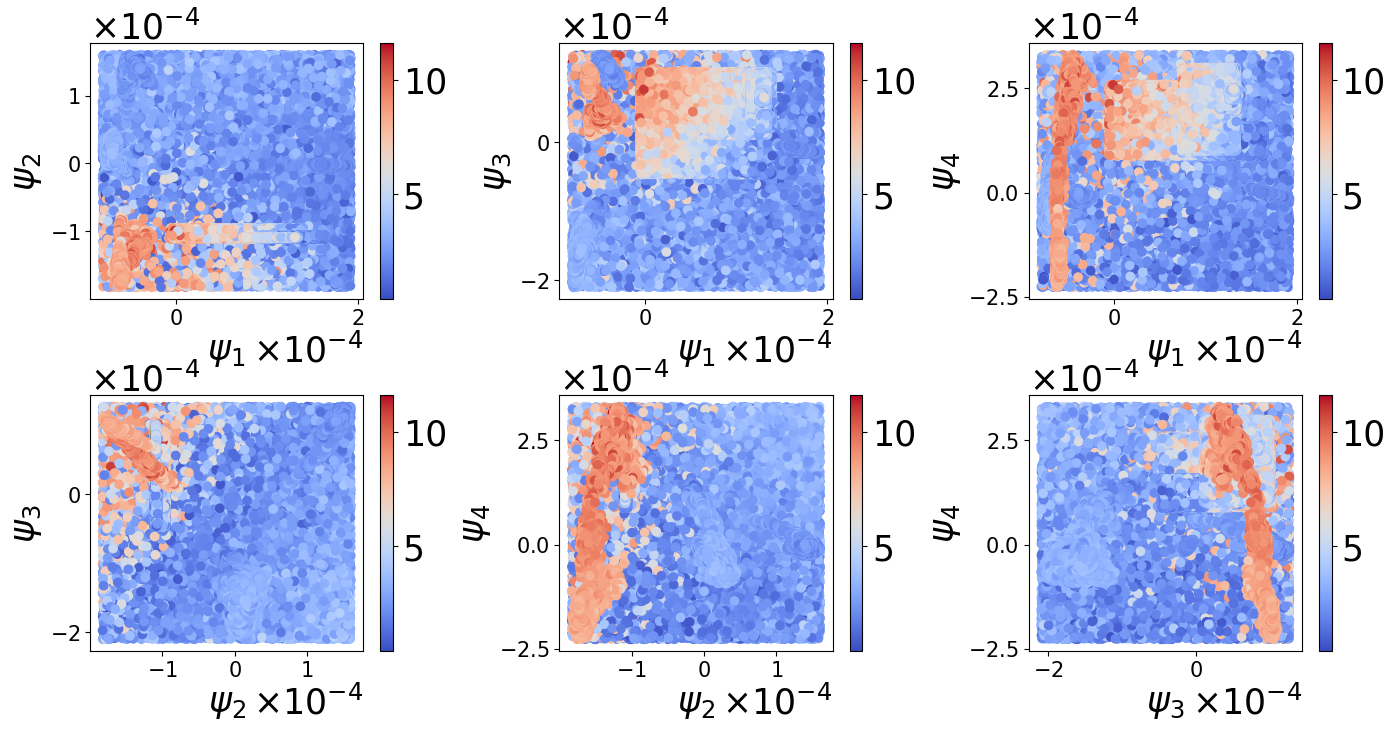

In [34]:
%matplotlib inline
### color 
colors = cog_tail_helices_cg_wgan/10
#colors = cog_beta_prop_beta_td_cg_wgan/10
#colors = cog_chains_cg_wgan/10
#colors = cog_headtail_cg_wgan/10

colorlabel=r'tail $\alpha_{helix}-\alpha_{helix}$ [nm]',
#colorlabel=r'$\beta_{Propeller}-\beta_{TD}$ [nm]'
#colorlabel=r'$\alpha_{unit}-\beta_{unit}$ [nm]'
#colorlabel=r'$head-tail$ [nm]'

ticks = list(np.arange(colors.min(), colors.max()))
diff_plots.plot2Dmaps(psi_relevant_space, 3.982, plot_stride=1, select_max_vecs=3, 
           skip_lead=False, colorMap=colors, cmap='coolwarm', colorbar=True, 
           colorlabel='',
           figSuffix='2d_relevant_space_taildistances_opt1')
            #, ticks=[10,12,14,16], offset=1, cticklabels=[10,12,14,16])


#diff_plots.plotmaps(psi, selected_e, plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap='coolwarm', colorbar=True,colorlabel=r'$\alpha_{helix}-\beta_{helix}$ [nm]', skip_3D=False, figSuffix = 'colorby_taildistances_opt1', ticks=None)


#### find where tail helices are minimum and maximum


In [1207]:
psi_dist_df = pd.DataFrame({'psi_2': psi_relevant_space[:90000,0], 'psi_3': psi_relevant_space[:90000,1],
                            'psi_4': psi_relevant_space[:90000,2], 'psi_5': psi_relevant_space[:90000,3],
                             'dist1': cog_tail_helices_cg_wgan[:90000]/10,
                             'dist2': cog_beta_prop_beta_td_cg_wgan[:90000]/10})
#psi_dist_df

In [1208]:
psi_dist_df[(psi_dist_df['dist1'] <= psi_dist_df['dist1'].min()+0.5) &  (psi_dist_df['dist2'] <= psi_dist_df['dist2'].min()+0.5)]

psi_dist_df[(psi_dist_df['dist1'] <= psi_dist_df['dist1'].min()+0.5) &  (psi_dist_df['dist2'] <= 6.5)]



,psi_2,psi_3,psi_4,psi_5,dist1,dist2
238,0.000192,-0.000140,0.000029,-0.000058,0.655824,6.240918
387,0.000179,-0.000073,0.000064,0.000078,0.642813,6.372204
1563,0.000190,-0.000078,-0.000003,0.000104,0.819413,6.302239
1757,0.000191,-0.000124,0.000031,-0.000004,0.725918,6.493935
3533,0.000176,-0.000133,-0.000079,0.000089,0.838543,6.385264
4058,0.000170,-0.000057,0.000118,-0.000115,0.675625,6.419901
5270,0.000191,-0.000126,0.000049,-0.000042,0.770308,6.467983
6859,0.000183,-0.000096,0.000115,0.000040,0.740628,6.410119
11486,0.000192,-0.000076,0.000026,0.000256,0.835355,6.419435
12152,0.000185,-0.000161,0.000005,0.000138,0.776794,6.491881


In [1209]:
psi_dist_df[(psi_dist_df['dist1'] >= psi_dist_df['dist1'].max()-4) &  
            (psi_dist_df['dist2'] <= psi_dist_df['dist2'].min()+2.5)]


,psi_2,psi_3,psi_4,psi_5,dist1,dist2


In [1196]:
#psi_dist_df[(psi_dist_df['dist1'] >= psi_dist_df['dist1'].max()-2) &  (psi_dist_df['dist2'] >= psi_dist_df['dist2'].max()-1.5
  #                                                                      )]

In [1171]:
#### read saved distances

#label_traj = ['bent', 'int1', 'int2', 'open']
#
#distances_cg_deadbolt_domains = []
#for i in range(len(label_traj)):
#    with open("integrin-analysis-data/basic_analysis_aa_model_data/distances_cg_deadbolt_domains_" +  label_traj[i] + ".pkl", 'rb') as f:
#        
#        distances_cg_deadbolt_domains.append(pickle.load(f))
#distances_cg_deadbolt_domains[]

In [39]:
psi_relevant_space.shape

(99800, 4)

#### save trajectory and distances 

In [42]:
psi_dist_df = pd.DataFrame({'psi_2': psi_relevant_space[:,0], 'psi_3': psi_relevant_space[:,1],
                            'psi_4': psi_relevant_space[:,2], 'psi_5': psi_relevant_space[:,3],
                             'tailh_dist': cog_tail_helices_cg_wgan/10,
                             'betap_dist': cog_beta_prop_beta_td_cg_wgan/10,
                             'chain_dist': cog_chains_cg_wgan/10,
                             'headtail_dist': cog_headtail_cg_wgan/10
                           })

psi_dist_df.to_pickle('./switchblade_deadbolt_gan_data_psi_distances.pkl')

In [44]:
with open(r"switchblade_deadbolt_gan_data_traj.pkl", "wb") as f:
    pickle.dump({'gen_traj_transition_points': np.array(gen_traj_transition_points)}, f)
   

In [50]:
psi_dist_df = pd.DataFrame({'psi_2': psi_relevant_space[:,0], 'psi_3': psi_relevant_space[:,1],
                            'psi_4': psi_relevant_space[:,2], 'psi_5': psi_relevant_space[:,3],
                             'tailh_dist': real_cog_tail_helices_cg_wgan/10,
                             'betap_dist': real_cog_beta_prop_beta_td_cg_wgan/10,
                             'chain_dist': real_cog_chains_cg_wgan/10,
                             'headtail_dist': real_cog_headtail_cg_wgan/10
                           })

psi_dist_df.to_pickle('./switchblade_deadbolt_gan_data_psi_distances_real.pkl')

In [51]:
with open(r"switchblade_deadbolt_gan_data_traj_real.pkl", "wb") as f:
    pickle.dump({'gen_traj_transition_points_real': np.array(gen_traj_transition_points_real)}, f)
   

In [288]:
from scipy.special import comb

def generate_2points_between(start_point, end_point, num_points):
    points = []
    step_size = 1.0 / (num_points - 1)
    for i in range(num_points):
        t = i * step_size
        x = start_point[0] + (end_point[0] - start_point[0]) * t
        y = start_point[1] + (end_point[1] - start_point[1]) * t
        points.append((x, y))
    return points


def generate_points_between(p0, p1, p2, p3, num_points):
    points = []
    for t in np.linspace(0, 1, num_points):
        x = (comb(3, 0) * (1 - t)**3 * p0[0]) + (comb(3, 1) * (1 - t)**2 * t * p1[0]) + (comb(3, 2) * (1 - t) * t**2 * p2[0]) + (comb(3, 3) * t**3 * p3[0])
        y = (comb(3, 0) * (1 - t)**3 * p0[1]) + (comb(3, 1) * (1 - t)**2 * t * p1[1]) + (comb(3, 2) * (1 - t) * t**2 * p2[1]) + (comb(3, 3) * t**3 * p3[1])
        points.append((x, y))
    
    return points


# switch
p0 = (cog_tail_helices_cg_wgan[3786]/10, cog_beta_prop_beta_td_cg_wgan[3786]/10)
p1 = (cog_tail_helices_cg_wgan[79391]/10, cog_beta_prop_beta_td_cg_wgan[3786]/10)
p2 = (cog_tail_helices_cg_wgan[69504]/10, cog_beta_prop_beta_td_cg_wgan[69504]/10)
p3 = (cog_tail_helices_cg_wgan[2076]/10, cog_beta_prop_beta_td_cg_wgan[2076]/10)
num_points = 10
switch_curve_points = generate_points_between(p0, p1, p2, p3, num_points)

# beta
p0 = (cog_tail_helices_cg_wgan[30094]/10, cog_beta_prop_beta_td_cg_wgan[30094]/10)
p1 = (cog_tail_helices_cg_wgan[13892]/10, cog_beta_prop_beta_td_cg_wgan[13892]/10)
p2 = (cog_tail_helices_cg_wgan[19254]/10, cog_beta_prop_beta_td_cg_wgan[19254]/10)
p3 = (cog_tail_helices_cg_wgan[15108]/10, cog_beta_prop_beta_td_cg_wgan[15108]/10)
num_points = 10
beta_curve_points = generate_points_between(p0, p1, p2, p3, num_points)

# mid
p0 = (cog_tail_helices_cg_wgan[4417]/10, cog_beta_prop_beta_td_cg_wgan[4417]/10)
p1 = (cog_tail_helices_cg_wgan[10372]/10, cog_beta_prop_beta_td_cg_wgan[10372]/10)
p2 = (cog_tail_helices_cg_wgan[20562]/10, cog_beta_prop_beta_td_cg_wgan[20562]/10)
p3 = (cog_tail_helices_cg_wgan[23980]/10, cog_beta_prop_beta_td_cg_wgan[23980]/10)
num_points = 6
mid_curve_points = generate_points_between(p0, p1, p2, p3, num_points)


def find_closest_index(tuple_data, target_point):
    closest_index = None
    closest_distance = float('inf')
    
    for i, element in enumerate(tuple_data):
        distance = math.dist(element, target_point)
        if distance < closest_distance:
            closest_distance = distance
            closest_index = i
    
    return closest_index


tuple_data = tuple(zip(cog_tail_helices_cg_wgan/10, cog_beta_prop_beta_td_cg_wgan/10))


switch_indices = [find_closest_index(tuple_data, switch_curve_points[i]) for i in range(len(switch_curve_points))]
beta_indices = [find_closest_index(tuple_data, beta_curve_points[i]) for i in range(len(beta_curve_points))]
mid_indices = [find_closest_index(tuple_data, mid_curve_points[i]) for i in range(len(mid_curve_points))]

all_indices = np.concatenate((switch_indices,beta_indices,mid_indices))
all_indices


array([ 3786, 16387, 87508, 86575, 87182, 72565, 46266, 17380,  2153,
        2076, 30094,  9605,  8258, 34757, 10350,    69, 92595,  6135,
       17841, 15108,  4417, 24602, 29023, 17621, 97458, 23980])

In [289]:
beta_2_curve_points

[(3.7696227759019534, 14.454286928056536),
 (3.888512464993876, 14.524670066662663),
 (4.007402154085799, 14.59505320526879),
 (4.126291843177722, 14.665436343874916)]

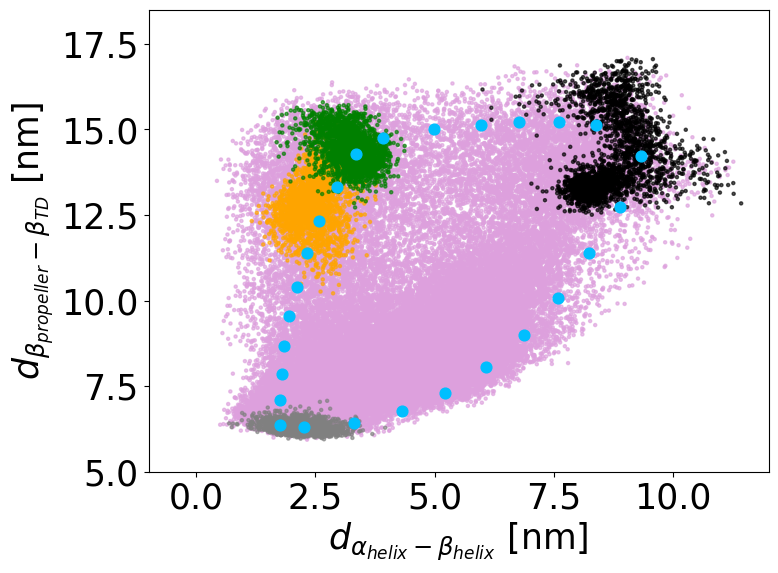

In [301]:
#%matplotlib notebook
%matplotlib inline

import mplcursors

# plot
fig = plt.figure(figsize=(8,6))


#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4, np.ones(psi1_psi2_space_data.shape[0])*5]
colors = [np.ones(psi1_psi2_space_data.shape[0])*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4, np.ones(2450)*5]

colors = np.concatenate(colors, axis=0)
lcmap = (mpl.colors.ListedColormap(['plum', 'gray', 'orange', 'green', 'black']) #'red', 'black'
        .with_extremes(over='0.25', under='0.75'))

ax1 = fig.add_subplot(111)

   
i=0
ax1.scatter(real_cog_tail_helices_cg_wgan/10,
            real_cog_beta_prop_beta_td_cg_wgan/10, c=colors, cmap=lcmap, s=5, alpha=0.65)

ax1.set_ylabel(r"$d_{\beta_{propeller}-\beta_{TD}}$ [nm]")
ax1.set_xlabel(r'$d_{\alpha_{helix}-\beta_{helix}}$ [nm]')

ax1.set_xlim(-1, 12)
ax1.set_ylim(5, 18.5)

#x = [418, 3786, 18327, 51791, 79391, 43725, 69504, 29833, 15738,
#     2076, 23980, 20461, 28012, 10455, 15168, 6008, 96288, 96987, 95561,
#     10216, 15325, 94516, 15368, 19254, 9998, 23878, 19244, 13892, 28696, 4063]
    
for fr in switch_indices:
    
    ax1.scatter(cog_tail_helices_cg_wgan[fr]/10, 
                cog_beta_prop_beta_td_cg_wgan[fr]/10, marker='o', s=60, color='deepskyblue', alpha=1)
    
    x = cog_tail_helices_cg_wgan[fr]/10
    y = cog_beta_prop_beta_td_cg_wgan[fr]/10
    label=fr
    #ax1.text(x, y, '%s' % (label), size=10, zorder=1, color='red')
    
for fr in beta_indices:
    
    ax1.scatter(cog_tail_helices_cg_wgan[fr]/10, 
                cog_beta_prop_beta_td_cg_wgan[fr]/10, marker='o', s=60, color='deepskyblue', alpha=1)
    
    x = cog_tail_helices_cg_wgan[fr]/10
    y = cog_beta_prop_beta_td_cg_wgan[fr]/10
    label=fr
    #ax1.text(x, y, '%s' % (label), size=10, zorder=1, color='red')
    
for fr in mid_indices:
    
    ax1.scatter(cog_tail_helices_cg_wgan[fr]/10, 
                cog_beta_prop_beta_td_cg_wgan[fr]/10, marker='o', s=60, color='deepskyblue', alpha=1)
    
    x = cog_tail_helices_cg_wgan[fr]/10
    y = cog_beta_prop_beta_td_cg_wgan[fr]/10
    label=fr
    #ax1.text(x, y, '%s' % (label), size=10, zorder=1, color='red')
       

mplcursors.cursor(ax1).connect("add", lambda sel: sel.annotation.set_text(sel.index))

# Set the number of ticks on the x-axis directly
num_ticks = 6
locator = ticker.MaxNLocator(num_ticks)
plt.gca().xaxis.set_major_locator(locator)

plt.show()
        
#fig.tight_layout()
    
#ax1.legend(fontsize=12, loc='lower right')#bbox_to_anchor=(1.1, 1.0),

#plt.tight_layout()
#fig.savefig("distance_cg_300_deadbolt_domains_2d.png",dpi=150)

In [269]:
90120, 55408, 16292, 24416, 

(90120, 55408, 16292, 24416)

In [270]:
gen_traj_transition_points_real.shape

(99800, 300, 3)

In [293]:

x = [418, 3786, 18327, 51791, 79391, 43725, 69504, 29833, 15738,
     2076, 23980, 20461, 28012, 10455, 15168, 6008, 96288, 96987, 95561,
     10216, 15325, 94516, 15368, 19254, 9998, 23878, 19244, 13892, 28696, 4063]

x = all_indices

selected_gen_traj_transition_points = gen_traj_transition_points_real[np.array(x)]
selected_gen_traj_transition_points.shape

(26, 300, 3)

In [294]:
### create a universe for CG model [from example in MDAnalysis]

n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe
cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates



### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
cg_1_universe.add_TopologyAttr('segid', ['INT'])

#### frame 0 positions

cg_1_universe.atoms.positions = selected_gen_traj_transition_points[0]

cg_1_universe.load_new(np.array(selected_gen_traj_transition_points), format=MemoryReader)


<Universe with 300 atoms>

In [296]:
view = nv.show_mdanalysis(cg_1_universe)

# clear representations
view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["800px", "600px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=3.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=3.5, opacity=0.85)
#view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=25)

In [303]:
print(all_indices)


[ 3786 16387 87508 86575 87182 72565 46266 17380  2153  2076 30094  9605
  8258 34757 10350    69 92595  6135 17841 15108  4417 24602 29023 17621
 97458 23980]


#### generate multiple conformations per each point in latent space

In [42]:
#uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

latent_points = [interpolate_points(psi[:,1:5][1000], psi[:,1:5][3000])]
latent_points.append( interpolate_points(psi[:,1:5][1000], psi[:,1:5][5000]) )
latent_points.append( interpolate_points(psi[:,1:5][3000], psi[:,1:5][5000]) )
latent_points.append( interpolate_points(psi[:,1:5][5000], psi[:,1:5][8000]) )
latent_points.append( interpolate_points(psi[:,1:5][1000], psi[:,1:5][8000]) )
latent_points.append( interpolate_points(psi[:,1:5][3000], psi[:,1:5][8000]) )



In [66]:
latent_points[0][0]

array([ 1.7035656e-04, -4.7090307e-06, -8.4624571e-06, -7.1479944e-06],
      dtype=float32)

In [73]:
latent_multiple_decoded_frames = []
for i in range(100):
    
    latent_multiple_decoded_frames.append(f_model_gan.generate(torch.tensor(latent_points[0]).float()).reshape(-1,300,3))


In [110]:
all_points = []
for j in range(len(latent_points[0])):
    point_1 = []
    for i in range(100):
        point_1.append(np.array(latent_multiple_decoded_frames[i][j]))
        
    all_points.append(np.array(point_1))

all_points = np.array(all_points)
#point_1

In [111]:
all_points.shape

(10, 100, 300, 3)

In [132]:
### create a universe for CG model [from example in MDAnalysis]
cg_1_universe = []
for i in range(all_points.shape[0]):
    n_residues = 300
    n_atoms = n_residues
    
    # create resindex list
    resindices = np.arange(n_residues)
    
    # all water molecules belong to 1 segment
    segindices = [0] * n_residues
    
    # create the Universe
    _cg_1_universe = mda.Universe.empty(n_atoms,
                                     n_residues=n_residues,
                                     atom_resindex=resindices,
                                     residue_segindex=segindices,
                                     trajectory=True) # necessary for adding coordinates
    
    ### topology attributes
    from MDAnalysis.coordinates.memory import MemoryReader
    
    _cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
    _cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
    _cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
    _cg_1_universe.add_TopologyAttr('segid', ['INT'])
    
    #### frame 0 positions
    
    _cg_1_universe.atoms.positions = all_points[i][0]
    
    _cg_1_universe.load_new(np.array(all_points[i]), format=MemoryReader)
    
    cg_1_universe.append(_cg_1_universe)
    

In [133]:
cg_1_universe

[<Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>]

In [136]:
#### save as PDB
for i in range(len(cg_1_universe)):
    cg_1_universe[i].atoms.write("multiple_fake_points_integrin/fake_point_"+str(i)+ ".gro")
    with mda.Writer("multiple_fake_points_integrin/fake_point_"+str(i)+".xtc", cg_1_universe[i].atoms.n_atoms) as W:
        for ts in cg_1_universe[i].trajectory:
            W.write(cg_1_universe[i].atoms.select_atoms("all"))



In [140]:
#### calculate RMSF
from MDAnalysis.analysis.rms import RMSF

rmsf_fake_points = []
for rep in cg_1_universe:
    print(rep)
    select_all_atoms = rep.select_atoms('index 0 to 299')
    rmsf_fake_points.append( RMSF(select_all_atoms).run() )

<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>


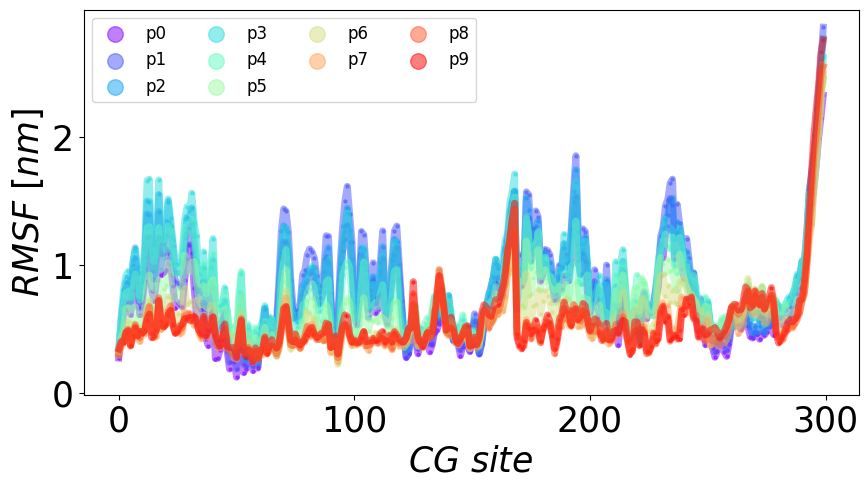

In [149]:
# plot
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.cm as cm

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(rmsf_fake_points)))
for i in range(len(rmsf_fake_points)):
    ax.scatter(list(np.arange(300)), rmsf_fake_points[i].results.rmsf/10, 
               color=colors[i], s=5, alpha=0.5, label='p'+str(i))

    ax.plot(list(np.arange(300)), rmsf_fake_points[i].results.rmsf/10, 
            color=colors[i], lw=5, alpha=0.5)
    
    
ax.legend(fontsize=12, ncol=4, markerscale=5)
ax.set_xlabel(r"$CG$ $site$")
ax.set_ylabel(r"$RMSF$ $[nm]$")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

ax.set_xlabel(r"$CG$ $site$")
ax.set_ylabel(r"$RMSF$ $[nm]$")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))


#plt.tight_layout()
#fig.savefig("rmsf_cg_300.png",dpi=150)

In [114]:
view = nv.show_mdanalysis(cg_1_universe)

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=3.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=3.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=99)

#### get RMSD over multiple decoded frames

In [115]:
all_points.shape

(10, 100, 300, 3)

In [116]:

#### save generated fake points

with open(r"integrin_aa_cg_300_multiple_fake_b100_e1000.pkl", "wb") as f:
    pickle.dump({'all_points': all_points}, f)
    
    

In [117]:
with open(r"integrin_aa_cg_300_multiple_fake_b100_e1000.pkl", "rb") as input_file:
    data_all_points = pickle.load(input_file)

all_points = data_all_points['all_points']


In [118]:
## calculate pairwise RMSD

import os
os.environ['LD_LIBRARY_PATH'] ="$LD_LIBRARY_PATH:/opt/apps/cuda/11.3/lib64"
os.environ['PATH']="$PATH:/opt/apps/xalt/xalt/bin:/opt/apps/cuda/11.3/bin"

for i in range(all_points.shape[0]):
    start = time.time()

    rmsd_jax.run_rmsd(jnp.array(all_points[i]), 
                      batch_ref_frame_size=10, 
                      nref_frames=all_points[i].shape[0] + 1, 
                      output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/gan_aa_cg_multiple_fake_data_b100_e1000/integrin_pair_rmsd_b100_"+str(i)+"_")

    print("RMSD calculations finished in {} seconds".format(time.time()-start))


running pairwise rmsd between same traj. Batch: 0
running pairwise rmsd between same traj. Batch: 10
running pairwise rmsd between same traj. Batch: 20
running pairwise rmsd between same traj. Batch: 30
running pairwise rmsd between same traj. Batch: 40
running pairwise rmsd between same traj. Batch: 50
running pairwise rmsd between same traj. Batch: 60
running pairwise rmsd between same traj. Batch: 70
running pairwise rmsd between same traj. Batch: 80
running pairwise rmsd between same traj. Batch: 90
RMSD calculations finished in 3.478280782699585 seconds
running pairwise rmsd between same traj. Batch: 0
running pairwise rmsd between same traj. Batch: 10
running pairwise rmsd between same traj. Batch: 20
running pairwise rmsd between same traj. Batch: 30
running pairwise rmsd between same traj. Batch: 40
running pairwise rmsd between same traj. Batch: 50
running pairwise rmsd between same traj. Batch: 60
running pairwise rmsd between same traj. Batch: 70
running pairwise rmsd betwee

In [119]:
## load pairwise RMSD
import os
os.environ['LD_LIBRARY_PATH'] ="$LD_LIBRARY_PATH:/opt/apps/cuda/11.3/lib64"
os.environ['PATH']="$PATH:/opt/apps/xalt/xalt/bin:/opt/apps/cuda/11.3/bin"


fake_sym_prmsd_jax_nm = []
for i in range(all_points.shape[0]):
    start = time.time()
    
    
    _sym_prmsd_jax = rmsd_jax.load_rmsd(nref_frames=all_points[i].shape[0] + 1, 
                                        batch_ref_frame_size=10, 
                                        input_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/gan_aa_cg_multiple_fake_data_b100_e1000/integrin_pair_rmsd_b100_"+str(i)+"_", 
                                        tol=1e-5)
    fake_sym_prmsd_jax_nm.append(_sym_prmsd_jax/10)



Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:

In [120]:
fake_sym_prmsd_jax_nm[9]

Array([[0.        , 1.1063513 , 1.0123312 , ..., 0.47247404, 0.83121157,
        0.8222373 ],
       [1.1063513 , 0.        , 1.1433907 , ..., 1.0384858 , 1.3285153 ,
        0.6791792 ],
       [1.0123312 , 1.1433907 , 0.        , ..., 1.0701363 , 0.9743665 ,
        1.0864699 ],
       ...,
       [0.47247404, 1.0384858 , 1.0701363 , ..., 0.        , 0.9274492 ,
        0.68907285],
       [0.83121157, 1.3285153 , 0.9743665 , ..., 0.9274492 , 0.        ,
        0.9538304 ],
       [0.8222373 , 0.6791792 , 1.0864699 , ..., 0.68907285, 0.9538304 ,
        0.        ]], dtype=float32)

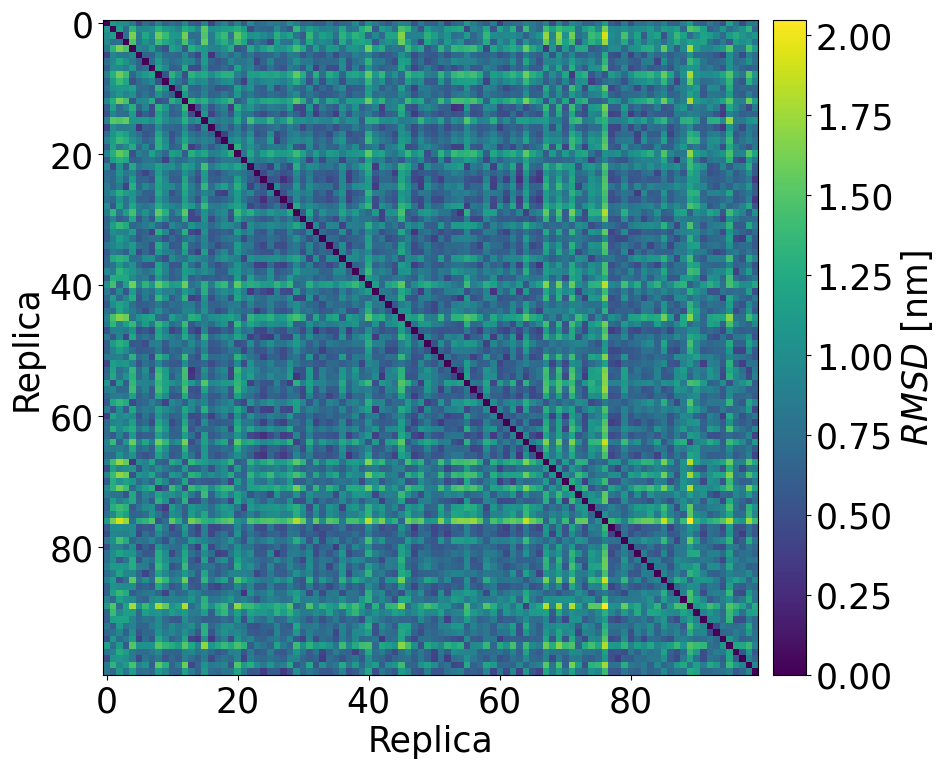

In [131]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))
#axes = axes.flatten()

#im1 = axes.imshow(sym_prmsd_jax_nm[0:2000,0:2000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[2000:4000,2000:4000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[4000:6000,4000:6000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[6000:8000,6000:8000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:11000,8000:11000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[11000:14000,11000:14000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:14000,8000:14000], cmap='viridis', vmin=0)
#axes.scatter(4274, 723, s=50, c='yellow')

im1 = axes.imshow(fake_sym_prmsd_jax_nm[9], cmap='viridis', vmin=0)


axes.set_xlabel('Replica')
axes.set_ylabel('Replica')


#axes.set_xticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))
#axes.set_yticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')


fig.tight_layout()    
#fig.savefig('jax-rmsd-integrin-full-gan-100batch-1000epoch.png',dpi=150)

/tmp/ipykernel_29707/2390957421.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(['bent', 'int1', 'int2', 'open'], size=18)


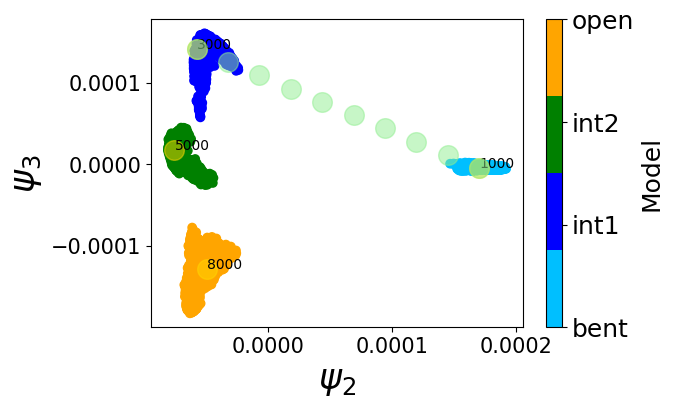

In [150]:
%matplotlib notebook
%matplotlib inline

import mplcursors

def plot3D_interactive(psi, eps, plot_stride=1, select_axis_2d=[1, 2], skip_lead=True, colorMap='blue', cmap='Accent', ticks=[1, 2, 3, 4, 5, 6], colorbar=True, colorlabel='Traj', skip_3D=False, figSuffix=''):

    if skip_lead:
        lead = 1
    else:
        lead = 0
    
    fig = plt.figure(figsize = (6,4))
    ax = fig.add_subplot(111)#, projection='3d')
    
    norm = plt.Normalize()
    color_map = plt.cm.coolwarm(norm(colorMap))
    
    im = ax.scatter(psi[::plot_stride,lead], psi[::plot_stride,lead+1], c=colorMap, cmap=cmap)
    
    for fr in [1000, 3000, 5000, 8000]:
        
        ax.scatter(psi[::plot_stride,1:4][fr][0], psi[::plot_stride,1:4][fr][1], marker='o', s=200, color='gold', alpha=.5)
        x = psi[::plot_stride,1:4][fr][0]
        y = psi[::plot_stride,1:4][fr][1]
        label=fr
        ax.text(x, y, '%s' % (label), size=10, zorder=1, color='black')
        
    for i in range(0,1):#len(latent_points)):
        ax.scatter(latent_points[i][:,0], latent_points[i][:,1], marker='o', s=200, color='lightgreen', alpha=.5)
        
        
    
    
    mplcursors.cursor(ax).connect("add", lambda sel: sel.annotation.set_text(sel.index))
    
    if colorbar:
        if ticks:
            cbar = plt.colorbar(im, ax=ax, ticks=ticks)
        else:
            cbar = plt.colorbar(im, ax=ax)
        #im.set_clim(model_loss_eigen['feat_evecs_SRV_unbiased'][:,ii+1].min(), model_loss_eigen['feat_evecs_SRV_unbiased'][:,ii+1].max())
        cbar.set_label(colorlabel, size=18)
        cbar.set_ticklabels(['bent', 'int1', 'int2', 'open'], size=18)
        
    
    ax.set_xlabel('$\psi$$_{'+str(lead+1)+'}$', labelpad=5)
    ax.set_ylabel('$\psi$$_{'+str(lead+2)+'}$', labelpad=5)
    #ax.set_zlabel('$\psi$$_{'+str(lead+3)+'}$', labelpad=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax.set_box_aspect(aspect=(4,4,4), zoom=0.8)
    
    # disable auto rotation
    #ax.zaxis.set_tick_params(labelsize=15)
    #ax.zaxis.set_rotate_label(False)
    
    
    plt.show()
        
    fig.tight_layout()
    #fig.savefig('interactive_evecs_'+str(lead+1)+str(lead+2)+str(lead+3)+'_'+str(eps)+ '_' + figSuffix + '.png', dpi=300)
    #plt.close()
        
colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4]
lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
        .with_extremes(over='0.25', under='0.75'))
#colors = tail_distances/10
plot3D_interactive(psi, '0', plot_stride=1, select_axis_2d=[1, 2], skip_lead=True, 
                   colorMap=colors, cmap=lcmap, colorlabel=r'Model', ticks=None,
                   colorbar=True, skip_3D=False, figSuffix = 'bytaildist_rotate_decode_opt1')


